# CSII 2024 Exercise 11: Nonlinear Control Part 1
&copy; 2024 ETH Zurich, Niclas Scheuer, Dejan Milojevic; Institute for Dynamic Systems and Control; Prof. Emilio Frazzoli

## Description
This week's Jupyter notebook will cover Feedback Linearization.

In [59]:
import numpy as np
from sympy import symbols, Matrix, diff
from sympy.utilities.lambdify import lambdify
from scipy.integrate import solve_ivp
from scipy.linalg import solve_continuous_are, inv
from matplotlib import pyplot as plt

## Exercise 1

In this exercise, we will review and recap the formulas associated with feedback linearization and implement them in Python. We will use the below non-linear system:

$ \begin{bmatrix} \dot{x_1} \\ \dot{x_2} \end{bmatrix} = 
\begin{bmatrix} x_2 \\ 2w(1-\mu x_1^2)x_2 -w^2x_1 \end{bmatrix} +
\begin{bmatrix} 0 \\ 1 \end{bmatrix} u $

$ y = x_1$

Where $w, \mu$ are constants that can be assumed $=1$.

### Exercise 1.1
The first step to linearizing the feedback law is to bring the system into the form: 

$\dot{x} = f(x) + g(x)u$

$y=h(x)$

We achieve this by using the ``sympy`` Matrix definition.

In [ ]:
w=1
mu=1
x1, x2 = symbols('x1 x2')
x = Matrix([x1, x2])

f = Matrix([x2, 2*w*(1-mu*x1**2)*x2 - w**2*x1])
g = 0 #TODO
h = 0 #TODO
f_func = lambdify((x1, x2), f, 'numpy')
g_func = #TODO
h_func = #TODO

### Solution 1.1

In [ ]:
w=1
mu=1
x1, x2 = symbols('x1 x2')
x = Matrix([x1, x2])

# Define the functions
f = Matrix([x2, 2*w*(1-mu*x1**2)*x2 - w**2*x1])
g = Matrix([0, 1])
h = Matrix([x1, 0])
f_func = lambdify((x1, x2), f, 'numpy')
g_func = lambdify((x1, x2), g, 'numpy')
h_func = lambdify((x1, x2), h, 'numpy')

### Exercise 1.2
In order to determine the *relative degree of the system*, we need to use the Lie Derivative $L_f$, $L_g$. This has been implemented below and works as follows:

$L_f h = $ ``lie_derivative(f, h, x)``.

Pay attention to the return types! ``result = lie_derivative(f, h, x)`` produces an object with the following members:
- ``result.matrix``: The matrix representation of the lie derivative. Use this for chained derivatives! Ex: ``lie_derivative(g, result.matrix, x)``
- ``result.func``: A lambdified version of the result. Ex: ``result.func(x1=1, x2=5)``
- ``result.value``: The most relevant output, simply the float or functional value of the lie derivative.

In [ ]:
class LieDerivative:
    def __init__(self, matrix, func, value):
        """Initialize the LieDerivative class."""
        self.matrix = matrix
        self.func = func
        self.value = value

def lie_derivative(vector_field: Matrix, function: Matrix, x: Matrix):
    """Calculate the Lie derivative of a function with respect to a vector field.
    
    Parameters:
    - ``vector_field``: The vector field.
    - ``function``: The function.
    - ``x``: The point at which to evaluate the Lie derivative.

    Returns:
    - ``LieDerivative``: The Lie derivative.
    """
    jacobian = function.jacobian(x)
    lie_matrix = jacobian*vector_field

    # Create function form
    lie_func = lambdify((x1, x2), lie_matrix[0], 'numpy')

    # Create value form
    lie_value = lie_matrix[0]
    
    return LieDerivative(lie_matrix, lie_func, lie_value)

Now that the fields $f(x), g(x), h(x)$ and the Lie Derivative are defined, calculate the *relative degree of the system* $\gamma$ using the following rule:

$\gamma$ is the smallest number such that $L_g L_f^{\gamma-1}h \neq 0$

In [ ]:
#TODO: Determine L_g L_f^0 h, check if equal to 0

#TODO: Determine L_g L_f^1 h, check if equal to 0

#TODO: ...

### Solution 1.2

In [ ]:
# Determine L_g L_f^0 h, which is equal to L_g h
lieg_h = lie_derivative(g, h, x)
print("gamma = 1 | L_g L_f^0 h = " + str(lieg_h.value))

# Determine L_g L_f^1 h, which is equal to L_g L_f h
lief_h = lie_derivative(f, h, x)
lieglief_h = lie_derivative(g, lief_h.matrix, x)
print("gamma = 2 | L_g L_f^1 h = " + str(lieglief_h.value))

# Relative Order of the system: 2
print("Therefore, the relative order of the system is 2.")

### Exercise 1.3
Now that the relative order of the system has been determined, we can make the system behave as the linear system $\frac{d^{\gamma}y}{dt^{\gamma}} = v$ by choosing:

$u = \frac{1}{L_g L_f^{\gamma-1}h(x)} (-L_f^{\gamma}h(x) +v)$

Using the found value of $\gamma$ and the function ``lie_derivative``, calculate u.

In [ ]:
v = symbols('v')
#TODO:
u = 0
print(u)

### Solution 1.3

In [ ]:
v = symbols('v')
lieg_lief_h = lie_derivative(g, lief_h.matrix, x)
print("Value of L_g L_f h = " + str(lieg_lief_h.value))

lief_lief_h = lie_derivative(f, lief_h.matrix, x)
print("Value of L_f L_f h = " + str(lief_lief_h.value))

u = 1/lieg_lief_h.value * (-lief_lief_h.value + v)
print(u)

### Exercise 1.4
Plugging the linearization controller $u(x_1, x_2, v)$ essentially yields the following:

$ \begin{bmatrix} \dot{x_1} \\ \dot{x_2} \end{bmatrix} = 
\begin{bmatrix} x_2 \\ 2w(1-\mu x_1^2)x_2 -w^2x_1 \end{bmatrix} +
\begin{bmatrix} 0 \\ 1 \end{bmatrix} \cdot (-2(1-\mu x_1^2)x_2 + w^2 x_1 + v) $

$ \begin{bmatrix} \dot{x_1} \\ \dot{x_2} \end{bmatrix} = 
\begin{bmatrix} 0 & 1 \\ 0 & 0  \end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} + 
\begin{bmatrix} 0 \\ 1 \end{bmatrix} v$

$y = \begin{bmatrix} 1 & 0 \end{bmatrix} x$

Therefore, we can now calculate a LQR controller using $A, B, C, D$. Once we find the control law $v = -Kx$, we just need to remember to pass it through $u(x_1, x_2, v)$.

In [113]:
# This is the only cell that has to be modified.
# TODO: Define system matrices
A = np.array([[0, 1], [0, 0]])
B = np.array([[0], [1]])
C = np.array([[1, 0]])
D = np.array([[0]])

# Define cost matrices
Q = np.array([[1, 0], [0, 1]])
R = np.array([[1]])

# TODO: Solve continuous ARE
P = solve_continuous_are(A, B, Q, R)

# TODO: Compute the LQR gain
K = np.linalg.inv(R) @ B.T @ P

In [124]:
def control_P(x):
    """This control law lacks any feedback linearization."""
    x_1, x_2 = x
    u = -K @ x
    return u

def control_linearization(x):
    """This control law simply does feedback linearization without LQR control. This means you can put any value of v in, and the system will have that slope."""
    x_1, x_2 = x
    v = 0
    u = -2*(1-x_1**2)*x_2 + x_1 + v
    return u

def control_law(x):
    """This control law includes LQR control and will stabilize the system to the origin."""
    x_1, x_2 = x
    v = -K @ x
    u = -2*(1-x_1**2)*x_2 + x_1 + v
    return u

In [125]:
def system_dynamics_no_control(t, x):
    x1, x2 = x
    x_dot = f_func(x1, x2)
    return x_dot.reshape(2,)

def system_dynamics_PID(t, x):
    x1, x2 = x
    x_dot = f_func(x1, x2) + g_func(x1, x2)*control_P(x)
    return x_dot.reshape(2,)

def system_dynamics_full(t, x):
    x1, x2 = x
    x_dot = f_func(x1, x2) + g_func(x1, x2)*control_law(x)
    return x_dot.reshape(2,)

def system_dynamics_linearized(t, x):
    x1, x2 = x
    x_dot = f_func(x1, x2) + g_func(x1, x2)*control_linearization(x)
    return x_dot.reshape(2,)

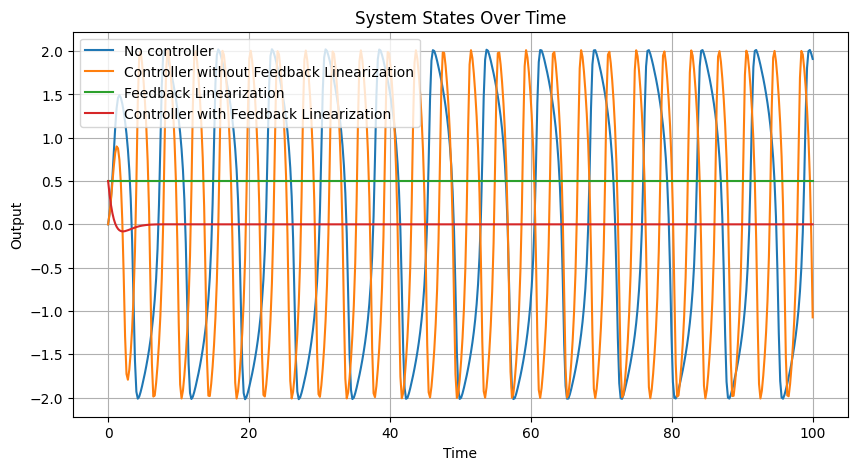

In [126]:
# Initial conditions
x0 = [0.0, 0.5]

# Time span
t_span = [0, 100]
t_eval = np.linspace(t_span[0], t_span[1], 500)

# Solving the differential equation
solution_no_control = solve_ivp(system_dynamics_no_control, t_span, x0, t_eval=t_eval)
solution_PID = solve_ivp(system_dynamics_PID, t_span, x0, t_eval=t_eval)
solution_linearized = solve_ivp(system_dynamics_linearized, t_span, x0, t_eval=t_eval)
solution_full = solve_ivp(system_dynamics_full, t_span, x0, t_eval=t_eval)

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(solution_no_control.t, solution_no_control.y[0], label='No controller')
plt.plot(solution_PID.t, solution_PID.y[0], label='Controller without Feedback Linearization')
plt.plot(solution_linearized.t, solution_linearized.y[1], label='Feedback Linearization')
plt.plot(solution_full.t, solution_full.y[1], label='Controller with Feedback Linearization')
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System States Over Time')
plt.legend()
plt.grid(True)
plt.show()